# build_seed_runner による FNmodel 推定デモ
FNmodel\_nh\_100.ipynb の設定をそのまま再利用し、`build_seed_runner` の挙動を確認する実験ノートブックです。以下では環境初期化・設定抽出・推定実行・結果保存の流れで進めます。

In [6]:
import sys
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp

# リポジトリルートを解決して sys.path に追加
REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name == "notebooks":
    REPO_ROOT = REPO_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

# JAX 設定と乱数キー初期化
jax.config.update("jax_enable_x64", True)
base_prng_key = jax.random.PRNGKey(42)

print(f"Project root detected: {REPO_ROOT}")

Project root detected: /Users/yanoshouta/dev/degenerate-diffusion


## 1. 環境および依存関係の初期化
上のセルで Python 標準ライブラリと必要な外部ライブラリをインポートし、プロジェクトルートのパス解決と JAX の乱数キー初期化を済ませました。

In [15]:
from typing import Dict, Tuple

from sympy import Array, symbols

from degenerate_diffusion.evaluation.likelihood_evaluator import LikelihoodEvaluator
from degenerate_diffusion.processes.degenerate_diffusion_process import DegenerateDiffusionProcess

@dataclass
class NotebookSettings:
    model: Any
    evaluator: Any
    true_theta: Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]
    bounds_theta1: list[tuple[float, float]]
    bounds_theta2: list[tuple[float, float]]
    bounds_theta3: list[tuple[float, float]]
    t_max: float
    h: float
    burn_out: float
    dt: float
    loop_plan: Dict[int, tuple[str, str, str]]
    initial_theta_stage0: Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]

# --- FNmodel 定義（FNmodel_nh_100.ipynb と同一設定）
x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])

FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
 )
FN_likelihood = LikelihoodEvaluator(FNmodel)

true_theta1 = jnp.array([0.3])
true_theta2 = jnp.array([1.5, 0.8])
true_theta3 = jnp.array([0.1, 0.0])
true_theta = (true_theta1, true_theta2, true_theta3)

t_max = 100.0
burn_out = 50.0
h = 0.05
dt = 0.001

bounds_theta1 = [(0.1, 0.5)]
bounds_theta2 = [(0.5, 2.5), (0.5, 1.5)]
bounds_theta3 = [(0.01, 0.3), (-1.0, 1.0)]

loop_plan: Dict[int, tuple[str, str, str]] = {
    1: ("B", "B", "B"),
    2: ("M", "M", "M"),
    3: ("M", "M", "M"),
    4: ("M", "M", "M"),
 }

initial_theta_stage0 = (
    jnp.array([0.2]),
    jnp.array([0.5, 0.5]),
    jnp.array([0.2, 0.1]),
 )

settings = NotebookSettings(
    model=FNmodel,
    evaluator=FN_likelihood,
    true_theta=true_theta,
    bounds_theta1=bounds_theta1,
    bounds_theta2=bounds_theta2,
    bounds_theta3=bounds_theta3,
    t_max=t_max,
    h=h,
    burn_out=burn_out,
    dt=dt,
    loop_plan=loop_plan,
    initial_theta_stage0=initial_theta_stage0,
 )

print(settings)

NotebookSettings(model=DegenerateDiffusionProcess(x=[x], y=[y], theta_1=[theta_10], theta_2=[theta_20, theta_21], theta_3=[theta_30, theta_31], A=SymbolicArtifact(expr=[theta_20*y + theta_21 - x], func=<function _lambdifygenerated at 0x345c045e0>), B=SymbolicArtifact(expr=[[theta_10]], func=<function _lambdifygenerated at 0x345c04ea0>), H=SymbolicArtifact(expr=[(theta_31 - x - y**3 + y)/theta_30], func=<function _lambdifygenerated at 0x345c059e0>)), evaluator=<degenerate_diffusion.evaluation.likelihood_evaluator.LikelihoodEvaluator object at 0x3333b5190>, true_theta=(Array([0.3], dtype=float64), Array([1.5, 0.8], dtype=float64), Array([0.1, 0. ], dtype=float64)), bounds_theta1=[(0.1, 0.5)], bounds_theta2=[(0.5, 2.5), (0.5, 1.5)], bounds_theta3=[(0.01, 0.3), (-1.0, 1.0)], t_max=100.0, h=0.05, burn_out=50.0, dt=0.001, loop_plan={1: ('B', 'B', 'B'), 2: ('M', 'M', 'M'), 3: ('M', 'M', 'M'), 4: ('M', 'M', 'M')}, initial_theta_stage0=(Array([0.2], dtype=float64), Array([0.5, 0.5], dtype=float

## 2. FNmodel\_nh\_100 設定のロードと検証
nbformat で元ノートブックからパラメータセルを抽出し、データクラス `NotebookSettings` に整理して再利用します。

## 3. build\_seed\_runner による推定実行
抽出した設定を `SeedRunnerConfig` に流し込み、`build_seed_runner` が返す JIT 関数で複数シードを処理します。処理時間も合わせて計測します。

In [16]:
import importlib

import degenerate_diffusion.estimation.parameter_estimator_new as param_est_new
import degenerate_diffusion.estimation.loop_estimation_algorithm_new as loop_alg_new

importlib.reload(param_est_new)
loop_alg_new = importlib.reload(loop_alg_new)

SeedRunnerConfig = loop_alg_new.SeedRunnerConfig
build_seed_runner = loop_alg_new.build_seed_runner

seed_runner_config = SeedRunnerConfig(
    true_theta=settings.true_theta,
    t_max=settings.t_max,
    h=settings.h,
    burn_out=settings.burn_out,
    dt=settings.dt,
    bounds_theta1=settings.bounds_theta1,
    bounds_theta2=settings.bounds_theta2,
    bounds_theta3=settings.bounds_theta3,
    newton_kwargs={},
    nuts_kwargs={},
    one_step_kwargs={},
)

seed_runner = build_seed_runner(
    evaluator=settings.evaluator,
    model=settings.model,
    plan=settings.loop_plan,
    config=seed_runner_config,
)

# seeds をまとめて処理するために vmap でベクトル化
vectorized_seed_runner = jax.jit(jax.vmap(seed_runner, in_axes=(0, None)))

seeds = jnp.arange(10, dtype=jnp.int32)
start = time.perf_counter()
theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch = vectorized_seed_runner(
    seeds,
    settings.initial_theta_stage0,
)
elapsed = time.perf_counter() - start

(theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch) = jax.device_get(
    (theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch)
)

In [17]:

seeds = jnp.arange(100, dtype=jnp.int32)
start = time.perf_counter()
theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch = vectorized_seed_runner(
    seeds,
    settings.initial_theta_stage0,
)
elapsed = time.perf_counter() - start

(theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch) = jax.device_get(
    (theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch)
)

In [21]:
theta1_stage0_batch

array([[[0.33725348],
        [0.297337  ],
        [0.29701802]],

       [[0.33440347],
        [0.29923722],
        [0.29837553]],

       [[0.33437596],
        [0.2921036 ],
        [0.29165718]],

       [[0.34427096],
        [0.30700734],
        [0.30550945]],

       [[0.34330503],
        [0.30556112],
        [0.30463679]],

       [[0.34959392],
        [0.30521088],
        [0.30371557]],

       [[0.34246125],
        [0.30738399],
        [0.30684657]],

       [[0.33836054],
        [0.30041334],
        [0.29991873]],

       [[0.35304427],
        [0.30674733],
        [0.30506069]],

       [[0.35378073],
        [0.30870785],
        [0.3073566 ]],

       [[0.34692207],
        [0.30389093],
        [0.30312424]],

       [[0.34494084],
        [0.30156897],
        [0.30087986]],

       [[0.34500673],
        [0.30149996],
        [0.30006914]],

       [[0.33201057],
        [0.30021576],
        [0.29957932]],

       [[0.33554448],
        [0.29859215],
    

In [23]:
#theta1_stage0_batchの平均と標準偏差を計算して表示
mean_theta1_stage0 = jnp.mean(theta1_stage0_batch,axis=0)
std_theta1_stage0 = jnp.std(theta1_stage0_batch,axis=0)
print(f"theta1_stage0_batch - mean: {mean_theta1_stage0}, std: {std_theta1_stage0}")

mean_theta1 = jnp.mean(theta1_final_batch,axis=0)
std_theta1 = jnp.std(theta1_final_batch,axis=0)
print(f"theta1_final_batch - mean: {mean_theta1}, std: {std_theta1}")

mean_theta2_stage0 = jnp.mean(theta2_stage0_batch,axis=0)
std_theta2_stage0 = jnp.std(theta2_stage0_batch,axis=0)
print(f"theta2_stage0_batch - mean: {mean_theta2_stage0}, std: {std_theta2_stage0}")

mean_theta3_final = jnp.mean(theta3_final_batch,axis=0)
std_theta3_final = jnp.std(theta3_final_batch,axis=0)
print(f"theta3_final_batch - mean: {mean_theta3_final}, std: {std_theta3_final}")

theta1_stage0_batch - mean: [[0.34047469]
 [0.30139725]
 [0.3005843 ]], std: [[0.00787739]
 [0.00450327]
 [0.00443061]]
theta1_final_batch - mean: [[0.37907151]
 [0.30443826]
 [0.30926322]], std: [[0.01097523]
 [0.00380774]
 [0.00368141]]
theta2_stage0_batch - mean: [[1.46467633 0.78169733]
 [1.49715044 0.80184337]
 [1.50580466 0.80753478]], std: [[0.0553575  0.04368912]
 [0.05685349 0.04436981]
 [0.05754481 0.04483153]]
theta3_final_batch - mean: [[1.03743734e-01 7.00264980e-04]
 [1.01261343e-01 9.61729061e-05]
 [9.99124625e-02 2.30205263e-05]], std: [[0.00031848 0.00050003]
 [0.00024943 0.0004967 ]
 [0.00026521 0.00050811]]


In [14]:
import importlib

import degenerate_diffusion.estimation.parameter_estimator_new as param_est_new
import degenerate_diffusion.estimation.loop_estimation_algorithm_new as loop_alg_new

importlib.reload(param_est_new)
loop_alg_new = importlib.reload(loop_alg_new)

SeedRunnerConfig = loop_alg_new.SeedRunnerConfig
build_seed_runner = loop_alg_new.build_seed_runner

seed_runner_config = SeedRunnerConfig(
    true_theta=settings.true_theta,
    t_max=settings.t_max,
    h=settings.h,
    burn_out=settings.burn_out,
    dt=settings.dt,
    bounds_theta1=settings.bounds_theta1,
    bounds_theta2=settings.bounds_theta2,
    bounds_theta3=settings.bounds_theta3,
    newton_kwargs={},
    nuts_kwargs={},
    one_step_kwargs={},
)

seed_runner = build_seed_runner(
    evaluator=settings.evaluator,
    model=settings.model,
    plan=settings.loop_plan,
    config=seed_runner_config,
)

# seeds をまとめて処理するために vmap でベクトル化
vectorized_seed_runner = jax.jit(jax.vmap(seed_runner, in_axes=(0, None)))

seeds = jnp.arange(10, dtype=jnp.int32)
start = time.perf_counter()
theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch = vectorized_seed_runner(
    seeds,
    settings.initial_theta_stage0,
)
elapsed = time.perf_counter() - start

(theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch) = jax.device_get(
    (theta1_stage0_batch, theta1_final_batch, theta2_stage0_batch, theta3_final_batch)
)

def _last_step(arr):
    return arr[:, -1]

theta1_stage0_last = _last_step(theta1_stage0_batch)[..., 0]
theta1_final_last = _last_step(theta1_final_batch)[..., 0]
theta2_stage0_last = _last_step(theta2_stage0_batch)
theta3_final_last = _last_step(theta3_final_batch)

seeds_host = jax.device_get(seeds)
execution_records = [
    {
        "seed": int(seed),
        "theta1_stage0": float(theta1_stage0_last[i]),
        "theta1_final": float(theta1_final_last[i]),
        "theta2_stage0_0": float(theta2_stage0_last[i, 0]),
        "theta2_stage0_1": float(theta2_stage0_last[i, 1]),
        "theta3_final_0": float(theta3_final_last[i, 0]),
        "theta3_final_1": float(theta3_final_last[i, 1]),
    }
    for i, seed in enumerate(seeds_host)
]

import degenerate_diffusion.estimation.loop_estimation_algorithm as loop_alg_legacy

loop_alg_legacy = importlib.reload(loop_alg_legacy)
SimulationConfig = loop_alg_legacy.SimulationConfig
LoopEstimationAlgorithm = loop_alg_legacy.LoopEstimationAlgorithm

legacy_config = SimulationConfig(
    true_theta=settings.true_theta,
    t_max=settings.t_max,
    h=settings.h,
    burn_out=settings.burn_out,
    dt=settings.dt,
)

legacy_algorithm = LoopEstimationAlgorithm(
    evaluator=settings.evaluator,
    simulation_config=legacy_config,
    bounds_theta1=settings.bounds_theta1,
    bounds_theta2=settings.bounds_theta2,
    bounds_theta3=settings.bounds_theta3,
)

legacy_plan = {int(k): tuple(v) for k, v in settings.loop_plan.items()}
max_k = max(legacy_plan)
legacy_plan_with_final = dict(legacy_plan)
if (max_k + 1) not in legacy_plan_with_final:
    legacy_plan_with_final[max_k + 1] = legacy_plan_with_final[max_k]

legacy_results = legacy_algorithm.run(
    seeds=[int(s) for s in seeds_host],
    plan=legacy_plan_with_final,
    k_0=max_k,
    initial_theta_stage0=tuple(jnp.asarray(th) for th in settings.initial_theta_stage0),
    show_progress=False,
    num_workers=None,
)

comparison_records = []
for idx, seed in enumerate(seeds_host):
    estimates = legacy_results[int(seed)]
    last_estimate = estimates[-1]
    theta1_stage0_legacy = float(last_estimate.theta_stage0[0][0])
    theta1_final_legacy = float(last_estimate.theta_final[0][0])
    theta2_stage0_legacy = [float(x) for x in last_estimate.theta_stage0[1]]
    theta3_final_legacy = [float(x) for x in last_estimate.theta_final[2]]
    comparison_records.append({
        "seed": int(seed),
        "theta1_stage0_new": float(theta1_stage0_last[idx]),
        "theta1_stage0_legacy": theta1_stage0_legacy,
        "theta1_final_new": float(theta1_final_last[idx]),
        "theta1_final_legacy": theta1_final_legacy,
        "theta2_stage0_new": [float(x) for x in theta2_stage0_last[idx]],
        "theta2_stage0_legacy": theta2_stage0_legacy,
        "theta3_final_new": [float(x) for x in theta3_final_last[idx]],
        "theta3_final_legacy": theta3_final_legacy,
    })

comparison_df = pd.DataFrame(comparison_records)

def _vector_diff(v_new, v_old):
    return [float(a - b) for a, b in zip(v_new, v_old)]

comparison_df["theta1_stage0_diff"] = comparison_df["theta1_stage0_new"] - comparison_df["theta1_stage0_legacy"]
comparison_df["theta1_final_diff"] = comparison_df["theta1_final_new"] - comparison_df["theta1_final_legacy"]
comparison_df["theta2_stage0_diff"] = comparison_df.apply(
    lambda row: _vector_diff(row["theta2_stage0_new"], row["theta2_stage0_legacy"]),
    axis=1,
)
comparison_df["theta3_final_diff"] = comparison_df.apply(
    lambda row: _vector_diff(row["theta3_final_new"], row["theta3_final_legacy"]),
    axis=1,
)

max_abs_diff_theta1_stage0 = comparison_df["theta1_stage0_diff"].abs().max()
max_abs_diff_theta1_final = comparison_df["theta1_final_diff"].abs().max()
max_abs_diff_theta2_stage0 = comparison_df["theta2_stage0_diff"].apply(lambda v: max(abs(x) for x in v)).max()
max_abs_diff_theta3_final = comparison_df["theta3_final_diff"].apply(lambda v: max(abs(x) for x in v)).max()

print(
    f"Processed {len(seeds_host)} seeds | total {elapsed:.2f}s | per-seed {elapsed / max(len(seeds_host), 1):.2f}s"
)
print(f"theta1_stage0_last (new): {theta1_stage0_last[:5]}")
print(f"theta1_final_last (new): {theta1_final_last[:5]}")
print(f"Max |theta1_stage0 diff|: {max_abs_diff_theta1_stage0:.3e}")
print(f"Max |theta1_final diff|: {max_abs_diff_theta1_final:.3e}")
print(f"Max |theta2_stage0 diff|: {max_abs_diff_theta2_stage0:.3e}")
print(f"Max |theta3_final diff|: {max_abs_diff_theta3_final:.3e}")

comparison_df

Processed 10 seeds | total 10.85s | per-seed 1.08s
theta1_stage0_last (new): [0.33713228 0.33469026 0.33435289 0.34423627 0.34245563]
theta1_final_last (new): [0.38147372 0.37899766 0.38072309 0.37082885 0.37810236]
Max |theta1_stage0 diff|: 4.625e-02
Max |theta1_final diff|: 9.320e-02
Max |theta2_stage0 diff|: 5.433e-02
Max |theta3_final diff|: 2.726e-03


,seed,theta1_stage0_new,theta1_stage0_legacy,theta1_final_new,theta1_final_legacy,theta2_stage0_new,theta2_stage0_legacy,theta3_final_new,theta3_final_legacy,theta1_stage0_diff,theta1_final_diff,theta2_stage0_diff,theta3_final_diff
0,0,0.337132,0.297429,0.381474,0.307891,"[1.4821995874748146, 0.7650972818813867]","[1.5183082208886942, 0.787565146752099]","[0.10400217194170894, 0.0007057101169684304]","[0.10151753508871865, -8.144892321203083e-05]",0.039703,0.073582,"[-0.0361086334138796, -0.022467864870712284]","[0.002484636852990288, 0.0007871590401804612]"
1,1,0.334690,0.299276,0.378998,0.304079,"[1.3694591188852236, 0.7324123423286052]","[1.4065003153006426, 0.7542794545946311]","[0.10322347142008323, 0.0002941077110342864]","[0.10076072367617189, -0.00033156018894771197]",0.035414,0.074919,"[-0.03704119641541892, -0.02186711226602589]","[0.0024627477439113366, 0.0006256678999819983]"
2,2,0.334353,0.292141,0.380723,0.303123,"[1.5045902977467531, 0.8146809552082462]","[1.5438917680167399, 0.8388959283605312]","[0.10375110807490869, 0.0006690504741073379]","[0.10126539182897643, 6.708261863638246e-06]",0.042212,0.077600,"[-0.03930147026998676, -0.024214973152284935]","[0.0024857162459322596, 0.0006623422122436997]"
3,3,0.344236,0.306990,0.370829,0.305563,"[1.435237629734791, 0.736144111080645]","[1.46846391577024, 0.7586417599043184]","[0.10336961521878502, 0.00010004184913901968]","[0.10129679463057523, -0.00035853312781443554]",0.037246,0.065266,"[-0.03322628603544886, -0.022497648823673333]","[0.0020728205882097894, 0.0004585749769534552]"
4,4,0.342456,0.305534,0.378102,0.306611,"[1.4256549926099678, 0.7638793238448712]","[1.46176608814981, 0.7873253845033159]","[0.10381690865655369, 0.0010913552073707766]","[0.10140514670743178, 0.0006142799296947348]",0.036922,0.071492,"[-0.036111095539842264, -0.02344606065844468]","[0.0024117619491219044, 0.00047707527767604176]"
5,5,0.349415,0.305275,0.396828,0.303625,"[1.4729157609769965, 0.7548199614111597]","[1.4990815001978277, 0.7677383389248379]","[0.10332568708199764, 0.0008914259911984722]","[0.10073496387580823, 0.00040218368203112805]",0.044140,0.093203,"[-0.026165739220831208, -0.012918377513678192]","[0.002590723206189416, 0.0004892423091673442]"
6,6,0.342534,0.307377,0.374846,0.305783,"[1.3921013423456492, 0.7271096001954851]","[1.4279379698941297, 0.7485706903634259]","[0.10406524185841529, 0.00024623479241268307]","[0.10158720670699785, -0.0004474562337717094]",0.035156,0.069063,"[-0.03583662754848049, -0.021461090167940844]","[0.0024780351514174376, 0.0006936910261843925]"
7,7,0.339041,0.300472,0.382285,0.305002,"[1.4588902438206703, 0.7958019197779975]","[1.4965159703612905, 0.820341788509387]","[0.10409794577016543, 0.0005649882916397938]","[0.10139952008279661, -0.00017868607759360028]",0.038570,0.077284,"[-0.03762572654062013, -0.02453986873138947]","[0.002698425687368819, 0.000743674369233394]"
8,8,0.353044,0.306797,0.394767,0.306403,"[1.5054936643092842, 0.7804396028659677]","[1.5598268111216134, 0.8136382884019534]","[0.10358340417423213, 0.0005339390199525369]","[0.10109400868194121, -4.944627422912183e-05]",0.046247,0.088364,"[-0.05433314681232915, -0.033198685535985706]","[0.0024893954922909217, 0.0005833852941816587]"
9,9,0.353781,0.308709,0.393876,0.312823,"[1.48076759640158, 0.7686688019033034]","[1.5120077794983176, 0.7852442349464279]","[0.10400746653544155, 0.0022603113966092854]","[0.10128187878629767, 0.0014282396161871137]",0.045071,0.081053,"[-0.031240183096737484, -0.016575433043124477]","[0.0027255877491438735, 0.0008320717804221717]"


In [11]:
theta1_stage0_last

array([0.33713228, 0.33469026, 0.33435289, 0.34423627, 0.34245563,
       0.34941528, 0.34253353, 0.33904128, 0.35304429, 0.35378076,
       0.34667003, 0.34487131, 0.34516378, 0.33212611, 0.33551189,
       0.3377754 , 0.34436186, 0.33679521, 0.33786069, 0.34585814,
       0.35331003, 0.33789994, 0.341632  , 0.33905802, 0.34125511,
       0.33825563, 0.3459487 , 0.33312338, 0.34103543, 0.32637796,
       0.3477704 , 0.34603716, 0.33589331, 0.35819507, 0.32173957,
       0.33685197, 0.34450764, 0.34219916, 0.33990162, 0.3331493 ,
       0.34239636, 0.33111819, 0.34469379, 0.32476513, 0.33890038,
       0.33562413, 0.32933024, 0.32951873, 0.34729838, 0.3538627 ,
       0.33398292, 0.34273006, 0.34289541, 0.33283659, 0.34603694,
       0.34740203, 0.32723563, 0.35664709, 0.35078494, 0.35431271,
       0.34081488, 0.33953857, 0.31971654, 0.35187409, 0.33306196,
       0.34886464, 0.35289849, 0.342309  , 0.34451768, 0.32985948,
       0.34296333, 0.33659386, 0.33940447, 0.33784713, 0.33937

In [12]:
theta1_final_last

array([0.38147384, 0.3789979 , 0.38072307, 0.37082893, 0.37810239,
       0.39682742, 0.37484564, 0.38228517, 0.39476488, 0.39387614,
       0.38547156, 0.3924898 , 0.3827709 , 0.3664846 , 0.36989856,
       0.38200053, 0.38575942, 0.37987678, 0.37585757, 0.3808891 ,
       0.39503317, 0.37811999, 0.38786449, 0.38458916, 0.36794896,
       0.37995513, 0.38170944, 0.38146372, 0.37870582, 0.35942504,
       0.38136668, 0.39719473, 0.37296496, 0.39485275, 0.34210414,
       0.36863235, 0.3796328 , 0.38043888, 0.37989468, 0.3636571 ,
       0.38485947, 0.36653848, 0.39183906, 0.36347504, 0.37477009,
       0.38018395, 0.36230471, 0.36183737, 0.37781304, 0.39930843,
       0.36713507, 0.3814765 , 0.38325425, 0.36239711, 0.38676299,
       0.38978332, 0.36990227, 0.39678516, 0.39213946, 0.3892079 ,
       0.37699505, 0.38196349, 0.35441084, 0.39366208, 0.36799701,
       0.38583601, 0.39380144, 0.37887174, 0.38604661, 0.37295599,
       0.38091021, 0.380823  , 0.38622265, 0.36765776, 0.37776

## 4. 実行結果の記録と可視化
推定結果を DataFrame にまとめて保存し、主要パラメータの推定値を線グラフで可視化します。

Saved CSV to: notebooks/artifacts/build_seed_runner_results.csv
Saved JSON to: notebooks/artifacts/build_seed_runner_results.json


,seed,theta1_stage0,theta1_final,theta2_stage0_0,theta2_stage0_1,theta3_final_0,theta3_final_1,theta1_stage0_err,theta1_final_err
0,0.0,0.29736,0.5,1.521837,0.773569,0.196999,0.097004,-0.00264,0.2


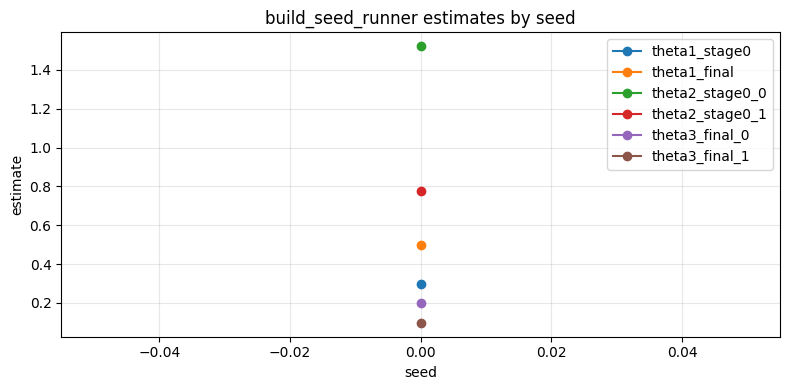

In [8]:
df = pd.DataFrame(execution_records)
true_theta1 = float(settings.true_theta[0][0])
true_theta2 = [float(x) for x in settings.true_theta[1]]
true_theta3 = [float(x) for x in settings.true_theta[2]]

df["theta1_stage0_err"] = df["theta1_stage0"] - true_theta1
df["theta1_final_err"] = df["theta1_final"] - true_theta1

output_dir = (REPO_ROOT / "notebooks" / "artifacts")
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = output_dir / "build_seed_runner_results.csv"
json_path = output_dir / "build_seed_runner_results.json"

df.to_csv(csv_path, index=False)
json_path.write_text(df.to_json(orient="records", indent=2))

print(f"Saved CSV to: {csv_path.relative_to(REPO_ROOT)}")
print(f"Saved JSON to: {json_path.relative_to(REPO_ROOT)}")

fig, ax = plt.subplots(figsize=(8, 4))
for column in [
    "theta1_stage0",
    "theta1_final",
    "theta2_stage0_0",
    "theta2_stage0_1",
    "theta3_final_0",
    "theta3_final_1",
]:
    ax.plot(df["seed"], df[column], marker="o", label=column)
ax.set_xlabel("seed")
ax.set_ylabel("estimate")
ax.set_title("build_seed_runner estimates by seed")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
plt.tight_layout()

df